# NBA play-by-play data + win probabilities

## Parts of this notebook:
1. Load play-by-play data from NBA API (or pre-read files)
2. Find team indices, winner of each game, adjustments for team strengths, clean data, etc.
2. Compute win probability and plot

In [1]:
import io
import time
import math
import datetime
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from datetime import date
import matplotlib.pyplot as plt
from nba_api.stats.static import teams
from nba_api.stats.endpoints import playbyplay
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import SeasonType
pd.set_option('display.max_rows',400)
fs,fsz=30,10 #font/figure size

# 1. Load play-by-play data from NBA API (or pre-read files)

# Much of the syntax below came from these resources: 
1. Rebuilding Owen Phillips blog post in Python (https://thef5.substack.com/p/how-to-pbp2)
2. https://github.com/Jman4190/NBAPlayByPlay/blob/main/free-throw-time-elapsed.py
3. The NBA API Slack page (from https://github.com/swar/nba_api)

A note on the below: the script below grabs two versions of every game, which differ based on whether an '@' or 'vs.' is used in the matchup field. I had lots of trouble paring this down at the read-in stage, so I now do so afterwards and create a new CSV with half of the data (one entry / game).

In [2]:
# Get NBA team IDs
# Game finder for season and season type
nba_teams = teams.get_teams() #grab generic team data
nba_team_ids = [team["id"] for team in nba_teams]
nba3=['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW',
      'HOU','IND','LAC','LAL','MEM','MIA','MIL','MIN','NOP','NYK',
      'OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WSH'] #quick 3-letter NBA codes

grabdata=0 #1=grab data from API (takes numerous hours!), 0=load pre-grabbed data
prepared=1 #loaded pre-grabbed data is ... 1=pared down,0=not pre-pared down
fy,ss=2004,17 #first year, # seasons to grab (2004-2021) (ignore 2001-2004, 29 teams, no Pelicans)
if grabdata:
    for i in range(ss): #loop through seasons
        for j in range(1): #seasons and postseasons
            pbpdata,count=[],0
            if i<10-5:
                season=str(i+fy) + '-0' + str(i+fy-2000+1)
            else: 
                season=str(i+fy) + '-' + str(i+fy-2000+1)
            #season=str(i+fy) + '-' + str(i+fy-2000+1) #override if only running seasons after 2009
            print(season)
            gamefinder=leaguegamefinder.LeagueGameFinder(season_nullable=season,timeout = 10)    
            time.sleep(1)
            # Extract game IDs
            games_dict = gamefinder.get_normalized_dict()
            games = games_dict["LeagueGameFinderResults"]
            game_ids = [game["GAME_ID"] for game in games if game["TEAM_ID"] in nba_team_ids] # filter to nba teams only
            matchups = [game["MATCHUP"] for game in games if game["TEAM_ID"] in nba_team_ids] # filter to nba teams only
            game_dates = [game["GAME_DATE"] for game in games if game["TEAM_ID"] in nba_team_ids] # filter to nba teams only
            for game_id in game_ids: #game_ids:
                df = playbyplay.PlayByPlay(game_id).get_data_frames()[0]
                df['matchup'],df['game_dates']=np.zeros((len(df))),np.zeros((len(df)))
                df['matchup'][:len(df)]=matchups[count]
                df['game_dates'][:len(df)]=game_dates[count]
                time.sleep(1) #add breaks so it doesn't time out
                count+=1
                pbpdata.append(df)
            df0 = pd.concat(pbpdata, ignore_index=True)
            fn="data/csvs/"+season+"data-1a.csv" #save doubled-up data
            df0.to_csv(fn) 
else: #load pre-grabbed data
    pbpdata_a=[]
    for i in range(ss): #loop through seasons
        df0=[]
        if i<10-5:
            season=str(i+fy) + '-0' + str(i+fy-2000+1)
        else: 
            season=str(i+fy) + '-' + str(i+fy-2000+1)
        print(season)
        if prepared==0:
            fn="data/csvs/"+season+"data-1a.csv"
            dfa=pd.read_csv(fn)
            print(len(dfa))
            ids=dfa.GAME_ID.unique()
            print('some game ids: %s' %ids[:10])
            print('total # games: %s' %len(ids)) #actual # games

            for ii,iii in enumerate(ids): #loop through all games
                qq=np.where(dfa['GAME_ID']==iii)[0] # find rows of this game
                match_i=dfa['matchup'][qq[0]]
                dft=dfa.iloc[qq]
                dft=dft[dft['matchup'][qq].str.match(match_i)] #only keep one of the versions of same game...
                if ii==0:
                    df0=dft.copy()
                else:
                    df0=dfc.append(dft)
            print('length of curtailed df:',len(df0))
            fn="data/csvs/"+season+"data.csv"
            df0.to_csv(fn) 
        else: #if you've run 'prepared=1' once, run again with it set to 0 for quicker load
            fn="data/csvs/"+season+"data.csv"
            df0=pd.read_csv(fn)
        pbpdata_a.append(df0)

2004-05
2005-06
2006-07
2007-08
2008-09
2009-10
2010-11
2011-12
2012-13
2013-14
2014-15
2015-16
2016-17
2017-18
2018-19
2019-20
2020-21


In [3]:
# concatenate data and clean up a bit
df0 = pd.concat(pbpdata_a, ignore_index=True) #concatenate data
df1 = df0[['GAME_ID','PERIOD','PCTIMESTRING','HOMEDESCRIPTION','NEUTRALDESCRIPTION','VISITORDESCRIPTION','SCOREMARGIN','matchup','game_dates']]
#figure out which rows relate to a tip, rebound, steal, or turnover
trst=np.zeros((len(df1)))
df2=df1[~df1['HOMEDESCRIPTION'].isna()]
temp=df2[df2['HOMEDESCRIPTION'].str.contains('Tip')] 
trst[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('Timeout')] 
trst[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('REBOUND')] 
trst[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('STEAL')] 
trst[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('Turnover')]
trst[temp.index]=1
df2=df1[~df1['VISITORDESCRIPTION'].isna()]
temp=df2[df2['VISITORDESCRIPTION'].str.contains('Tip')] 
trst[temp.index]=1
temp=df2[df2['VISITORDESCRIPTION'].str.contains('Timeout')] 
trst[temp.index]=1
temp=df2[df2['VISITORDESCRIPTION'].str.contains('REBOUND')] #df1
trst[temp.index]=1
temp=df2[df2['VISITORDESCRIPTION'].str.contains('STEAL')]
trst[temp.index]=1
temp=df2[df2['VISITORDESCRIPTION'].str.contains('Turnover')] 
trst[temp.index]=1

#df1 = df1[np.logical_or(~df1['SCOREMARGIN'].isnull(),~df1['NEUTRALDESCRIPTION'].isnull())] #old way
df1 = df1[np.logical_or(np.logical_or(~df1['SCOREMARGIN'].isnull(),~df1['NEUTRALDESCRIPTION'].isnull()),trst)] #kill nans

#fix score to 0 at beginning of game
print('num total rows:',len(df1))
ids=df1.GAME_ID.unique()
print('total # games: %s' %len(ids)) #games
for i,ii in enumerate(ids): #loop through all games
    qq=np.where(df1['GAME_ID']==ii)[0] # find rows of this game
    df1['SCOREMARGIN'][df1.index[qq[0]]]=0
    if i%3000==0: #print progress
        print('current:',i)
#df1=df1[~df1['SCOREMARGIN'].isnull()] #get rid of timeouts - old way
df1=df1.replace(to_replace="TIE",value="0") #replace TIE with 0 margin
df1[:5] #print some play-by-play data points, to get a sense

num total rows: 5683581
total # games: 22539
current: 0


<ipython-input-3-d4589547b88f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['SCOREMARGIN'][df1.index[qq[0]]]=0


current: 3000
current: 6000
current: 9000
current: 12000
current: 15000
current: 18000
current: 21000


,GAME_ID,PERIOD,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCOREMARGIN,matchup,game_dates
0,40400407,1,12:00,NaN,Start of 1st Period (9:36 PM EST),NaN,0,DET @ SAS,2005-06-23
1,40400407,1,12:00,Jump Ball Mohammed vs. B. Wallace: Tip to Parker,NaN,NaN,NaN,DET @ SAS,2005-06-23
2,40400407,1,11:41,Duncan 9' Jump Bank Shot (2 PTS),NaN,NaN,2,DET @ SAS,2005-06-23
4,40400407,1,11:11,NaN,NaN,R. Wallace 12' Jump Shot (2 PTS),0,DET @ SAS,2005-06-23
5,40400407,1,10:54,Ginobili 19' Jump Shot (2 PTS),NaN,NaN,2,DET @ SAS,2005-06-23


In [4]:
#clean up, rename columns, create 'seconds left' data 
#fix time to be just seconds left in the game
svec=np.zeros((len(df1))) #seconds vector
print('length of df1:',len(df1))
for i in range(len(df1)):
    if df1['PCTIMESTRING'][df1.index[i]][1].isdigit():
        minu=int(df1['PCTIMESTRING'][df1.index[i]][:2])
        sec=int(df1['PCTIMESTRING'][df1.index[i]][3:5])
    else:
        minu=int(df1['PCTIMESTRING'][df1.index[i]][:1])
        sec=int(df1['PCTIMESTRING'][df1.index[i]][2:4])
    if df1['PERIOD'][df1.index[i]]<=4:
        svec[i]=int((4-df1['PERIOD'][df1.index[i]])*12*60+minu*60+sec)
    else:
        svec[i]=int((4-df1['PERIOD'][df1.index[i]])*5*60+minu*60+sec)
    if i%1000000==0: #print progress
        print('fix time loop progress: %s',i)

#grab relevant data and clean up
df1['sl']=svec
df1.index=np.arange(0,len(df1)) #start index over
hvmat=np.zeros((len(svec))) #home or visitor possession matrix
df2=df1[~df1['VISITORDESCRIPTION'].isna()]
temp=df2[df2['VISITORDESCRIPTION'].str.contains('PTS')] #visitor scores
hvmat[temp.index]=1
temp=df2[df2['VISITORDESCRIPTION'].str.contains('Free Throw 1 of 2')] #but if mid-FTs, change back
hvmat[temp.index]=0
temp=df2[df2['VISITORDESCRIPTION'].str.contains('Free Throw 1 of 3')]
hvmat[temp.index]=0
temp=df2[df2['VISITORDESCRIPTION'].str.contains('Free Throw 2 of 3')] 
hvmat[temp.index]=0
temp=df2[df2['VISITORDESCRIPTION'].str.contains('Tip')] 
hvmat[temp.index]=0
temp=df2[df2['VISITORDESCRIPTION'].str.contains('Timeout')] 
hvmat[temp.index]=0
temp=df2[df2['VISITORDESCRIPTION'].str.contains('REBOUND')]
hvmat[temp.index]=0
temp=df2[df2['VISITORDESCRIPTION'].str.contains('STEAL')]
hvmat[temp.index]=0
temp=df2[df2['VISITORDESCRIPTION'].str.contains('Turnover')] 
hvmat[temp.index]=1
df2=df1[~df1['HOMEDESCRIPTION'].isna()]
temp=df2[df2['HOMEDESCRIPTION'].str.contains('Free Throw 1 of 2')]
hvmat[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('Free Throw 1 of 3')]
hvmat[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('Free Throw 2 of 3')] 
hvmat[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('Tip')]
hvmat[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('Timeout')] 
hvmat[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('REBOUND')] 
hvmat[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('STEAL')] 
hvmat[temp.index]=1
temp=df2[df2['HOMEDESCRIPTION'].str.contains('Turnover')] 
hvmat[temp.index]=0

df1['hp']=hvmat
#shorten some names
df1=df1.rename(columns={"SCOREMARGIN": "sdiff","GAME_ID":"g_id","game_dates":"g_d"}) 

length of df1: 5683581
fix time loop progress: %s 0
fix time loop progress: %s 1000000
fix time loop progress: %s 2000000
fix time loop progress: %s 3000000
fix time loop progress: %s 4000000
fix time loop progress: %s 5000000


# negative rows in OT 46528
# negative rows in 2OT 6882
# negative rows in 3OT 1139
# negative rows in 4OT 152
# negative rows in 5OT 0


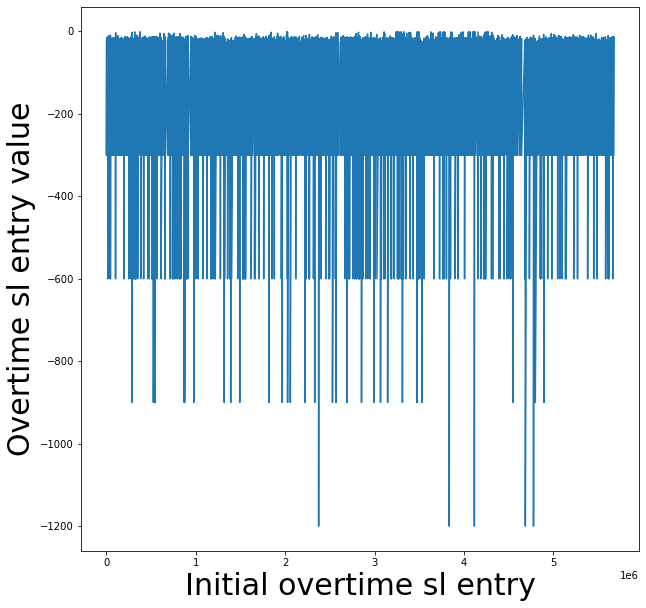

In [5]:
#create 'seconds left' variable that's NOT negative for OT. this is critical for computing win prob later.
sl_ot=deepcopy(df1['sl']) 
qq=np.where(df1['sl']<0)
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
qq=np.where(sl_ot<0)[0] 
ax.plot(sl_ot[qq])
ax.set_xlabel('Initial overtime ''sl'' entry',fontsize=fs)
ax.set_ylabel('Overtime ''sl'' entry value',fontsize=fs)
print('# negative rows in OT',len(qq))
sl_ot[qq]=sl_ot[qq]+(60*5)
qq=np.where(sl_ot<0)[0] #repeat for 2OT, etc.
print('# negative rows in 2OT',len(qq))
sl_ot[qq]=sl_ot[qq]+(60*5) 
qq=np.where(sl_ot<0)[0] 
print('# negative rows in 3OT',len(qq))
sl_ot[qq]=sl_ot[qq]+(60*5) 
qq=np.where(sl_ot<0)[0]
print('# negative rows in 4OT',len(qq))
sl_ot[qq]=sl_ot[qq]+(60*5) 
qq=np.where(sl_ot<0)[0]
print('# negative rows in 5OT',len(qq))
sl_ot[qq]=sl_ot[qq]+(60*5) 
df1['sl_ot'] = sl_ot

In [6]:
#create index of team IDs (so e.g., Atlanta Hawks (ATL) = 0) and fix for team moves over the years
ids=df1.g_id.unique()
v_ind,h_ind=np.zeros((len(df1))),np.zeros((len(df1)))
print('total # games: %s' %len(ids)) #games
for i,ii in enumerate(ids): #loop through all games
    for ha in range(2): #visitor, then home
        qq=np.where(df1['g_id']==ii)[0] # find rows of this game
        if len(df1['matchup'][df1.index[qq[0]]])==9: #if code uses @    
            if ha==0:
                tstr=df1['matchup'][df1.index[qq[0]]][:3]
            elif ha==1:
                tstr=df1['matchup'][df1.index[qq[0]]][6:9]
        elif len(df1['matchup'][df1.index[qq[0]]])==11: #if code uses vs.
            if ha==0:
                tstr=df1['matchup'][df1.index[qq[0]]][8:11]
            elif ha==1:
                tstr=df1['matchup'][df1.index[qq[0]]][:3]
        if tstr=='SEA': #correct teams who've moved / codes have changed
            tstr='OKC'
        elif tstr=='NJN':
            tstr='BKN'
        elif tstr=='CHH':
            tstr='CHA'
        elif tstr=='WAS':
            tstr='WSH'
        elif tstr=='NOH':
            tstr='NOP'
        elif tstr=='NOK':
            tstr='NOP'
        if ha==0:
            if tstr in nba3:
                v_ind[qq]=nba3.index(tstr)
            else:
                #print('oddity:',tstr)
                v_ind[qq]=-50
        elif ha==1:
            if tstr in nba3:
                h_ind[qq]=nba3.index(tstr)
            else:
                #print('oddity:',tstr)
                h_ind[qq]=-50
        if np.logical_and(ha==1,i%3000==0):
            print(i)

df1['home']=h_ind
df1['vis']=v_ind

#what % of rows are pure NBA games?
qq=np.where(df1['home']+df1['vis']>0)[0]
print(len(qq)/len(df1))

sdiffvec=df1['sdiff'].values
sdiffvec2=deepcopy(sdiffvec) 
sdiff_last=0
for i in range(len(sdiffvec)):
    q=sdiffvec[i]
    if isinstance(q, float): #isnan
        sdiffvec2[i]=sdiff_last
    if isinstance(q, str): #isstring
        sdiffvec2[i]=int(q)
    sdiff_last=sdiffvec2[i]+0
    if i%2000000==0: #print progress
        print('progress: %s',i)
        print(sdiffvec2)

df1['sdiff']=sdiffvec2

total # games: 22539
0
3000
6000
9000
12000
15000
18000
21000
0.9970024180177954
progress: %s 0
[0 nan '2' ... '-23' '-21' '-21']
progress: %s 2000000
[0 0 2 ... '-23' '-21' '-21']
progress: %s 4000000
[0 0 2 ... '-23' '-21' '-21']


In [7]:
#determine whether home team won or lost
df1=df1[['g_id','g_d','sl','sdiff','hp','home','vis']] #pare down data to essentials
ldf=len(df1)
hw=np.zeros((ldf))
ids=df1.g_id.unique()
print('some game ids: %s' %ids[:10])
print('total # games: %s' %len(ids)) #games

#also add clean time info for each game 
year_mat,month_mat,day_mat=np.zeros((ldf)),np.zeros((ldf)),np.zeros((ldf))
for i,ii in enumerate(ids): #loop through all games
    qq=np.where(df1['g_id']==ii)[0] # find rows of this game
    last=-1
    if int(df1['sdiff'][qq[last]])>0: #if home team won
        hw[qq]=1
    else:
        hw[qq]=0
    year_mat[qq]=int(df1['g_d'][qq[0]][:4])
    month_mat[qq]=int(df1['g_d'][qq[0]][5:7])
    day_mat[qq]=int(df1['g_d'][qq[0]][8:10])
    if i%10000==0:
        print('home win loop progress:',i)
df1['hw']=hw
df1['sl_ot']=sl_ot
df1['year']=year_mat
df1['month']=month_mat
df1['day']=day_mat
df1[['year','month','day','sdiff']] = df1[['year','month','day','sdiff']].astype(int)

some game ids: [40400407 40400406 40400405 40400404 40400403 40400402 40400401 40400307
 40400306 40400305]
total # games: 22539
home win loop progress: 0
home win loop progress: 10000
home win loop progress: 20000


Heretofore we've found the score difference, but this doesn't account at all for team strength (so every game starts with the same home win %, every team has same likelihood of surmounting the same deficit, etc.). Here we adjust the 'score difference' column by creating an 'adjusted score difference' that reads in each team's points scored minus points against from that season and adjust by a 'point differential expected per second' that we can just multiply by the # of seconds remaining.

In [8]:
df_svr=pd.read_excel('Sports memory rubric.xlsx',sheet_name='SeasonsVsRecords',header=0) #read in data
print('length:',len(df_svr))
sdiff_adj=np.zeros((ldf))
for i,ii in enumerate(ids): #loop through all games
    qq=np.where(df1['g_id']==ii)[0] # find rows of this game
    yr,mth=df1['year'][qq[0]],df1['month'][qq[0]]
    if yr!=2020: #not bubble year
        if mth>8: #if happens in early part of season
            szn=yr+0
        else:
            szn=yr-1 #if happens in late part
    else:
        if mth>11: #early part of 2020 season
            szn=yr+0
        else:
            szn=yr-1
    hm,vis=df1['home'][qq[0]],df1['vis'][qq[0]]
    df_svrt=df_svr[df_svr['Starting year']==szn]
    #expected point difference between two teams over the course of a game
    if hm+vis>0: #if found in the regular NBA database
        h_v_diff=df_svrt['PSPAdiff'][df_svrt.index[hm]]-df_svrt['PSPAdiff'][df_svrt.index[vis]] 
        h_v_diff_ps=h_v_diff/(12*4*60) #convert to expected difference / second
        slvec=df1['sl_ot'][qq].values #seconds left vector
        sdiff_adj[qq]=np.round(df1['sdiff'][qq]+np.multiply(slvec,h_v_diff_ps))
    else:
        sdiff_adj[qq]=df1['sdiff'][qq]
df1['sdiff_adj']=sdiff_adj

length: 540


       g_id         g_d    sl  sdiff  hp  home  vis  hw  sl_ot  year  month  \
0  40400407  2005-06-23  2880      0   0    26    8   1   2880  2005      6   
1  40400407  2005-06-23  2880      0   1    26    8   1   2880  2005      6   

   day  sdiff_adj       hwp      mwwp       sur     fgsur     wgsur    maxsur  \
0   23          4  0.702929  0.319512       NaN  0.297071  0.680488  0.098775   
1   23          4  0.702634  0.319512 -0.000295  0.297071  0.680488  0.098775   

   mwwp_t  
0  1184.0  
1  1184.0  


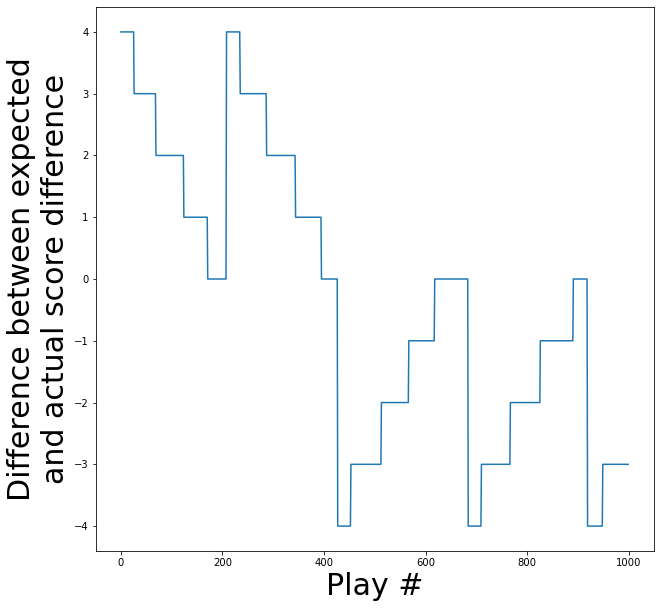

In [17]:
#plot a few games worth of the difference between true and adjusted score
#note how it goes to 0 by game's end
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
ax.plot(df1['sdiff_adj'][:1000]-df1['sdiff'][:1000])
ax.set_xlabel('Play #',fontsize=fs)
ax.set_ylabel('''Difference between expected
and actual score difference''',fontsize=fs)

#clean up every relevant row into the 'int' format for win prob quantification + save
df1[['g_id','sl','sl_ot','sdiff_adj','hp','home','vis','hw']]=df1[['g_id','sl','sl_ot','sdiff_adj','hp','home','vis','hw']].astype(int)
print(df1[:2])

# Create win probability space
Here we compute win probabilities using 4 factors (as in Antony et al., 2021):
- The score difference before each possession.
- The points scored / game - points scored against / game _difference_ between the teams for that season (difference in team strength)
- (The two above are wrapped into one metric below: the _expected_ score difference using the actual score difference and the expected difference in later scores given team strengths)
- The amount of time left in the game
- The team in possession of the ball

In [10]:
print('approximate home win percentage, for shiggles: %s' %np.mean(hw)) #~mean home win %
#loop through all games
xsd,nsd,tSec=30,-30,12*4*60 #score difference boundaries, # sec / game
scoreDiffSteps=1+xsd-nsd
scoreDiffB=np.linspace(nsd,xsd,scoreDiffSteps) #create score difference vector
print(scoreDiffB[:5])
secSteps=int(tSec/6)  
secB0=np.linspace(int(tSec),0,secSteps+1) #time left vector
#added to refine end of game!
secB=deepcopy(secB0)
secB[-1]=4
secB=np.append(secB,2)
secB=np.append(secB,0).astype(int)
secSteps=secSteps+2
#4-factor win probability space
fact4i=np.zeros((secSteps,scoreDiffSteps,2)) #two in final dimension for home / away
wp=np.zeros((ldf)) #assign this to new df1 column after this loop

tr_half=0 # 0=train all,1=train half, using ID of game ~ halfway
runloadd=0 #1=run space data (takes many minutes!),0=load pre-grabbed data
if runloadd:
    for i in range(secSteps): #all second bins
        for j in range(scoreDiffSteps): #all score bins
            for k in range(2): #home/away
                c=0
                kk=(k+1)%2 #0=home,1=away
                #find all games w/ game state and calculate how often they won
                #smooth for non-final state
                #include 0 sec left because of fractions of seconds ... will correct end of game % below
                if i<2:
                    #q=np.where(np.logical_and(np.logical_and(np.logical_and(np.logical_and(
                        #df1['sl_ot']<=secB[i],df1['sl_ot']>=secB[i+1]),df1['sdiff_adj']>=scoreDiffB[j]-1),
                        #df1['sdiff_adj']<=scoreDiffB[j]+1),df1['hp']==kk))[0]
                    q=np.where(np.logical_and(np.logical_and(np.logical_and(np.logical_and(
                        df1['sl_ot']<=secB[i],df1['sl_ot']>=secB[i+1]),df1['sdiff_adj']>scoreDiffB[j]-1),
                        df1['sdiff_adj']<=scoreDiffB[j]),df1['hp']==kk))[0]
                elif i==secSteps-1:
                    q=np.where(np.logical_and(np.logical_and(np.logical_and(np.logical_and(
                        df1['sl_ot']<secB[i],df1['sl_ot']>=secB[i+1]),df1['sdiff_adj']>scoreDiffB[j]-1),
                        df1['sdiff_adj']<=scoreDiffB[j]),df1['hp']==kk))[0]
                else:
                    q=np.where(np.logical_and(np.logical_and(np.logical_and(np.logical_and(
                        df1['sl_ot']<secB[i-1],df1['sl_ot']>=secB[i+2]),df1['sdiff_adj']>scoreDiffB[j]-1),
                        df1['sdiff_adj']<=scoreDiffB[j]),df1['hp']==kk))[0] #NOTE THE 2! different
                if len(q>1):
                    for l in range(len(q)):
                        c+=df1['hw'][q[l]]
                    fact4i[i,j,k]=c/len(q) #calculate wp 
                    wp[q]=c/len(q) #assign wp values in the dataframe
                else:
                    fact4i[i,j,k]=math.nan
        if i%50==0: #Print progress
            print(i)

    #create max/min WP just to avoid 100% confidence and related data issues
    q=np.where(df1['sdiff_adj']>scoreDiffB[-1])
    wp[q]=0.998 #ceiling
    q=np.where(df1['sdiff_adj']<scoreDiffB[0])[0]
    wp[q]=0.002 #ceiling
    
    ids=df1.g_id.unique()
    for i,ii in enumerate(ids): #loop through all games
        qq=np.where(df1['g_id']==ii)[0] # find rows of this game
        if df1['sdiff'][qq[-1]]>0: #if home team won
            wp[qq[-1]]=1
        elif df1['sdiff'][qq[-1]]<0: #if vis team won
            wp[qq[-1]]=0
        q1=np.where(np.diff(df1['sl_ot'][qq])>0)[0] #if there's any overtime(s)
        if len(q1)>0:
            wp[qq[q1]]=wp[qq[0]] #set state to original home win prob
    
    fact4i2=fact4i[int(secSteps/2):,:,:] #pare down to only 2nd half 
    fact4i2[-1,1,0]=0 #one missing context, was nan, mark as 0
    secB2=secB0[int(secSteps/2):]
    np.save('pydata/fact4i2.npy',fact4i2)
    np.save('pydata/secB2.npy',secB2)
    np.save('pydata/wp.npy',wp)
else:
    fact4i2=np.load('pydata/fact4i2.npy')
    secB2=np.load('pydata/secB2.npy')
    wp=np.load('pydata/wp.npy')
df1['hwp']=wp
print(fact4i2.shape)
print(secB2.shape)

approximate home win percentage, for shiggles: 0.5900206225617265
[-30. -29. -28. -27. -26.]
(241, 61, 2)
(240,)


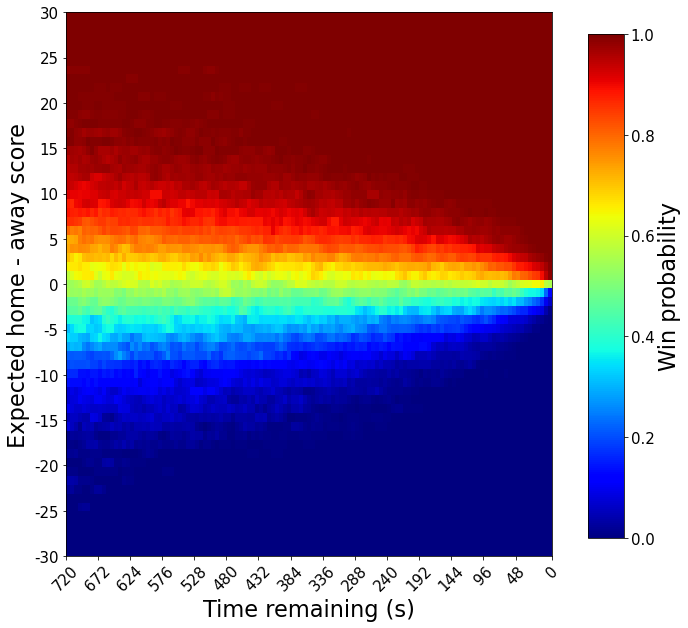

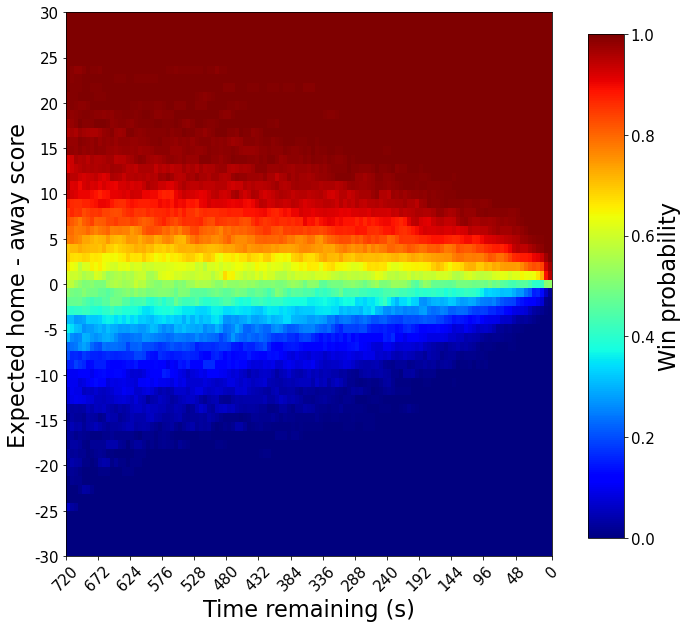

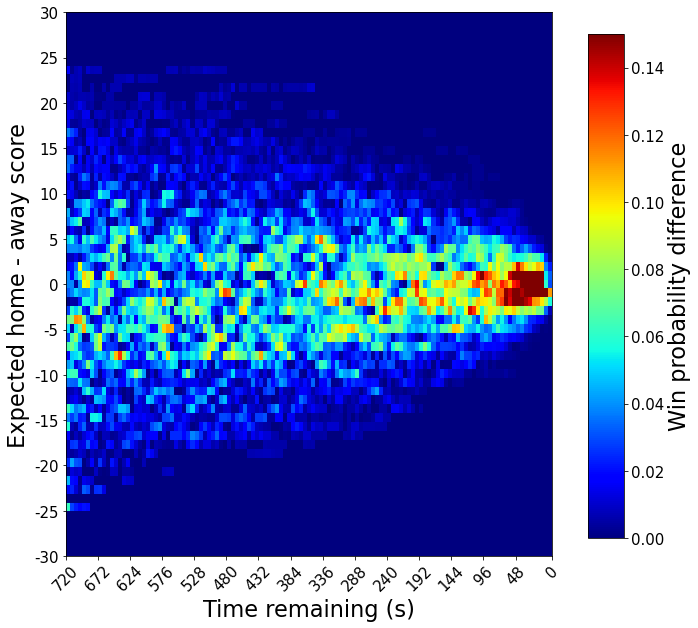

In [11]:
#create wp look-up table based on 3 factors (collapsing team strength + score into 'adjusted wp')
def wpplot(dat,xmx,cbl,sl,vm,vx,pltsin,figp,trh): #function for plotting in wp space
    xdivf,ydivf=8,5
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    im=ax.imshow(dat[xmx:,:].T,interpolation='none',aspect='auto',cmap='jet',vmin=vm,vmax=vx)
    ax.set_ylabel('Expected home - away score',fontsize=fs*0.75)
    ax.set_xlabel('Time remaining (s)',fontsize=fs*0.75)
    xt=np.linspace(-0.5,xmx-0.5,int(np.divide(xmx,xdivf))+1)
    xt[-1]=xt[-1]+1
    ax.set_xticks(xt)
    xtl=sl[xmx-1::xdivf].astype(int)
    ax.set_xticklabels(xtl, rotation = 45,fontsize=fs//2)
    ax.set_yticks(np.linspace(-0.5,scoreDiffSteps-0.5,int(np.divide(scoreDiffSteps-1,ydivf))+1))
    ax.set_yticklabels(scoreDiffB[::ydivf].astype(int),fontsize=fs//2)
    ax.invert_yaxis() #invert y axis for preferred viz
    f.subplots_adjust(right=0.8) #adjust so we can add colorbar
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar=f.colorbar(im, cax=cbar_ax)
    cbar.set_label(cbl,fontsize=fs*0.75)
    cbar.ax.tick_params(labelsize=fs//2)
    if pltsin: #add sin wave to show periodicity of wp advantage
        time=np.arange(0, 120, 0.1);
        amplitude=np.sin(time*(np.pi)/3.5-9)*5
        ax.plot(time[:-1],amplitude[:-1]+xsd,'k',linewidth=2)
        plt.show()
    if figp>0:
        fn='figs/wpplot'+str(figp)+'-'+str(trh)+'.pdf'
        f.savefig(fn, transparent=True)

q4i=int(np.divide(secSteps-2,4))
wpplot(fact4i2[:,:,0],q4i,'Win probability',secB2,0,1,0,1,tr_half)
wpplot(fact4i2[:,:,1],q4i,'Win probability',secB2,0,1,0,2,tr_half)
wpplot(abs(fact4i2[:,:,0]-fact4i2[:,:,1]),q4i,'Win probability difference',secB2,0,0.15,0,3,tr_half)
#wpplot(abs(fact4i2[:,:,0]-fact4i2[:,:,1]),q4i,'Win probability difference',secB2,0,0.15,1,4,tr_half)

In [12]:
ldf=len(df1)
#find minimum WP of winning team - used later to compute comeback data
#create surprise data
mwwp,fgsur,mwwp_t,sur,maxsur=np.zeros((ldf)),np.zeros((ldf)),np.zeros((ldf)),np.zeros((ldf)),np.zeros((ldf))
wgsur=np.zeros((ldf))
ids,k=df1.g_id.unique(),0
print('# games:',len(ids))
for i,ii in enumerate(ids): #loop through all games
    qq=np.where(df1['g_id']==ii)[0] # find rows of this game
    if int(df1['sdiff'][qq[-1]])>0: #if home team won
        minwwp=np.min(df1['hwp'][qq]) #find minimum hwp
        #use absolute here because there are some miniscule rounding errors
        mwwpi=np.where(np.absolute(df1['hwp'][qq]-minwwp)<0.0001)[0]
        firstwwp=df1['hwp'][qq[0]]
        fgsur[qq]=1-df1['hwp'][qq[0]]
        wgsur[qq]=1-minwwp
    else: #away team won
        minwwp=1-np.max(df1['hwp'][qq]) #find maximum hwp
        mwwpi=np.where(np.absolute(df1['hwp'][qq]-(1-minwwp))<0.0001)[0]
        firstwwp=1-df1['hwp'][qq[0]]
        fgsur[qq]=0-df1['hwp'][qq[0]]
        wgsur[qq]=-minwwp
    mwwp_t_i=df1['sl'][qq[mwwpi[0]]]
    mwwp_t[qq]=mwwp_t_i+0 #time in game of moment furthest from comeback        
    mwwp[qq]=minwwp
    
    #find 'diff' matrix on wps, move it all back one (so surprise is aligned w/ beginning of possession) 
    #and nan out 1st entry
    diffmat=np.diff(df1['hwp'][qq])
    sur[qq[0]]=math.nan
    sur[qq[1]:qq[-1]+1]=diffmat
    curr_maxsur=np.max(diffmat)
    maxsur[qq]=curr_maxsur
    if k==0: 
        maxsurs,mwwps,mwwp_ts,fwwps=curr_maxsur+0,minwwp+0,mwwp_t_i+0,firstwwp+0
        allsurs=diffmat.T
        k=1
    else:
        maxsurs=np.vstack([maxsurs,curr_maxsur])
        mwwps=np.vstack([mwwps,minwwp])
        mwwp_ts=np.vstack([mwwp_ts,mwwp_t_i])
        fwwps=np.vstack([fwwps,firstwwp])
        allsurs=np.hstack([allsurs,diffmat.T])
    if i%10000==0: #progress
        print(i)
df1['mwwp']=mwwp
df1['sur']=sur
df1['fgsur']=fgsur
df1['wgsur']=wgsur
df1['maxsur']=maxsur
df1['mwwp_t']=mwwp_t

#save data
df1.to_csv('pydata/df1.csv',index=False) 
np.save('pydata/allsurs.npy',allsurs)
np.save('pydata/secB.npy',secB)
np.save('pydata/mwwps.npy',mwwps)
np.save('pydata/mwwp_ts.npy',mwwp_ts)
np.save('pydata/maxsurs.npy',maxsurs)
np.save('pydata/fwwps.npy',fwwps)

# games: 22539
0
10000
20000


In [13]:
#compare our model to linear and logistic regression (using the same factors)
#qq=np.where(df1['sl_ot'].values<300)[0] #last 5 minutes only, just to check
qq=np.where(df1['sl_ot'].values<3000)[0] #whole game

#try a linear model
x0=df1['sl_ot'][qq].values #predictors
x1=df1['sdiff_adj'][qq].values
x2=df1['hp'][qq].values
y=df1['hw'][qq].values #outcome
y_4f=df1['hwp'][qq].values #our 4-factor model outcome
x=np.vstack([x0,x1])
x=np.vstack([x,x2]).T
print(x.shape)
print(y.shape)
model = LinearRegression().fit(x, y) #fit model
y_pred = model.predict(x)
mean_err_lin=np.mean(np.absolute(y-y_pred))
print('mean err of linear regression:',mean_err_lin)
model = LogisticRegression().fit(x, y)
y_pred = model.predict_proba(x) #don't use '.predict' - it just guesses the winner!
mean_err_lin=np.mean(np.absolute(y-y_pred[:,1]))
print('mean err of logistic regression:',mean_err_lin)
mean_err_4f=np.mean(np.absolute(y-y_4f))
print('mean err of 4-factor model:',mean_err_4f)

(5683581, 3)
(5683581,)
mean err of linear regression: 0.35459055763822256
mean err of logistic regression: 0.31643139655644037
mean err of 4-factor model: 0.3044969859516888


In [22]:
#print some outputs of interest: 
print('# rows in PBP data:',ldf)
print('win prob differences going from -4 to +4 with e.g., 5 s left:\n',fact4i2[-3,26:35,0])
print('win prob differences going from -4 to +4 with e.g., 3 s left:\n',fact4i2[-2,26:35,0])
print('win prob differences going from -4 to +4 with e.g., 1 s left:\n',fact4i2[-1,26:35,0])

# rows in PBP data: 5683581
win prob differences going from -4 to +4 with e.g., 5 s left:
 [0.01603376 0.08893709 0.17523168 0.339381   0.65497553 0.89768977
 0.94323144 0.98408104 0.99840256]
win prob differences going from -4 to +4 with e.g., 3 s left:
 [0.00565771 0.04014599 0.10049261 0.22432432 0.57545487 0.94714286
 0.96659708 0.99221032 1.        ]
win prob differences going from -4 to +4 with e.g., 1 s left:
 [0.         0.01027397 0.06465517 0.12933754 0.55480379 0.98644068
 0.99204244 0.99773243 1.        ]
